In [1]:
import random


class Game:
    ACTION_UP = 0
    ACTION_LEFT = 1
    ACTION_DOWN = 2
    ACTION_RIGHT = 3

    ACTIONS = [ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT, ACTION_UP]

    ACTION_NAMES = ["UP", "LEFT", "DOWN", "RIGHT"]

    MOVEMENTS = {
        ACTION_UP: (1, 0),
        ACTION_RIGHT: (0, 1),
        ACTION_LEFT: (0, -1),
        ACTION_DOWN: (-1, 0)
    }

    num_actions = len(ACTIONS)

    def __init__(self, n, m, wrong_action_p=0.1, alea=False):
        self.n = n
        self.m = m
        self.wrong_action_p = wrong_action_p
        self.alea = alea
        self.generate_game()



    def _position_to_id(self, x, y):
        """Donne l'identifiant de la position entre 0 et 15"""
        return x + y * self.n

    def _id_to_position(self, id):
        """Réciproque de la fonction précédente"""
        return (id % self.n, id // self.n)

    def generate_game(self):
        cases = [(x, y) for x in range(self.n) for y in range(self.m)]
        hole = random.choice(cases)
        cases.remove(hole)
        start = random.choice(cases)
        cases.remove(start)
        end = random.choice(cases)
        cases.remove(end)
        block = random.choice(cases)
        cases.remove(block)

        self.position = start
        self.end = end
        self.hole = hole
        self.block = block
        self.counter = 0
        
        if not self.alea:
            self.start = start
        return self._get_state()
    
    def reset(self):
        if not self.alea:
            self.position = self.start
            self.counter = 0
            return self._get_state()
        else:
            return self.generate_game()

    def _get_grille(self, x, y):
        grille = [
            [0] * self.n for i in range(self.m)
        ]
        grille[x][y] = 1
        return grille

    def _get_state(self):
        if self.alea:
            return [self._get_grille(x, y) for (x, y) in
                    [self.position, self.end, self.hole, self.block]]
        return self._position_to_id(*self.position)

    def move(self, action):
        """
        takes an action parameter
        :param action : the id of an action
        :return ((state_id, end, hole, block), reward, is_final, actions)
        """
        
        self.counter += 1

        if action not in self.ACTIONS:
            raise Exception("Invalid action")

        # random actions sometimes (2 times over 10 default)
        choice = random.random()
        if choice < self.wrong_action_p:
            action = (action + 1) % 4
        elif choice < 2 * self.wrong_action_p:
            action = (action - 1) % 4

        d_x, d_y = self.MOVEMENTS[action]
        x, y = self.position
        new_x, new_y = x + d_x, y + d_y

        if self.block == (new_x, new_y):
            return self._get_state(), -1, False, self.ACTIONS
        elif self.hole == (new_x, new_y):
            self.position = new_x, new_y
            return self._get_state(), -10, True, None
        elif self.end == (new_x, new_y):
            self.position = new_x, new_y
            return self._get_state(), 10, True, self.ACTIONS
        elif new_x >= self.n or new_y >= self.m or new_x < 0 or new_y < 0:
            return self._get_state(), -1, False, self.ACTIONS
        elif self.counter > 190:
            self.position = new_x, new_y
            return self._get_state(), -10, True, self.ACTIONS
        else:
            self.position = new_x, new_y
            return self._get_state(), -1, False, self.ACTIONS

    def print(self):
        str = ""
        for i in range(self.n - 1, -1, -1):
            for j in range(self.m):
                if (i, j) == self.position:
                    str += "x"
                elif (i, j) == self.block:
                    str += "¤"
                elif (i, j) == self.hole:
                    str += "o"
                elif (i, j) == self.end:
                    str += "@"
                else:
                    str += "."
            str += "\n"
        print(str)

In [2]:
# create table Q-valeurs init dimnsion 16*4 full of 0
def init_q_table():
    return [[0 for i in range(4)] for j in range(16)]


In [69]:
from math import inf


def Q_valeurs(n):
    table = init_q_table()
    game = Game(4, 4)
    game.print()
    best_reward = -inf
    list_reward = []
    for i in range(n):
        state = game.reset()
        end = False
        final_reward = 0
        while end != True:
            action_random = random.choice(game.ACTIONS)
            action_best = table[state].index(max(table[state]))
            action = random.choices([action_random, action_best], weights=[0.1, 0.9])[0]
            
            next_state, reward, end, actions = game.move(action)
            final_reward += reward
            # print(next_state)
            table[state][action] = table[state][action] + 0.1 * (reward + 0.9 * max(table[next_state]) - table[state][action])
            # print(state)
            state = next_state
        list_reward.append(final_reward)
        if final_reward > best_reward:
            best_reward = final_reward

    return table, best_reward, list_reward


In [74]:
table, best_reward, list_reward = Q_valeurs(1000)
print(table)
print(best_reward)


..¤.
....
..@o
..x.

[[-0.19, -0.199, -0.199, 2.0414708819036327], [-0.2897119, -0.199, -0.199, -0.21646567083449803], [-0.28, -0.2881, -0.30349000000000004, -0.2659669638238729], [-0.199, -0.199, -0.20863900000000002, -0.10900000000000001], [0.5433560736050685, 0.18807331076094802, 2.19516863435776, 5.291912992646755], [-0.057542978959080934, -0.10900000000000001, 2.736836099832008, 0], [-0.2881, -0.28891, -0.2543966696851779, 0.6586631684154103], [-0.199, -0.19, -0.2881, -0.199], [8.218131326633184, 5.2082340779178855, 5.810428313911241, 3.89636967311135], [0, 0, 0, 0], [-0.1, -0.219254646889, 4.2659174283026635, 0], [0, 0, 0, 0], [-5.217031, 5.049666580042632, 0.9084692285060899, -0.6690903386271898], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
10


Text(0.5, 0, 'iterations')

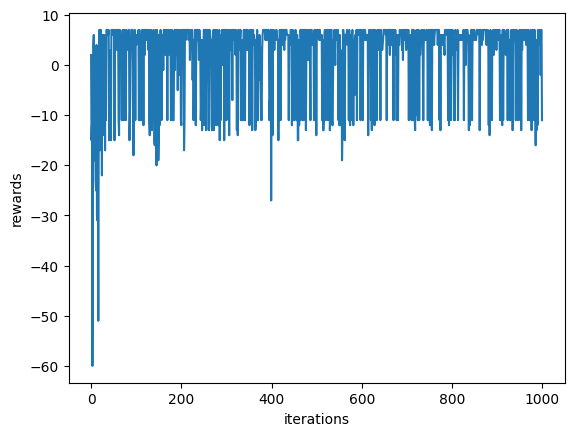

In [71]:
import matplotlib.pyplot as plt
plt.plot(list_reward)
plt.ylabel('rewards')
plt.xlabel('iterations')

In [73]:
import pygame
import random

# Initialisation de Pygame
pygame.init()

# Dimensions de l'écran
width, height = 640, 480
screen = pygame.display.set_mode((width, height))

# Couleurs
black = (0, 0, 0)
white = (255, 255, 255)
red = (255, 0, 0)

# Dimensions d'une cellule
cell_size = 20

# Vitesse du serpent
snake_speed = 10

# Définition des polices
font = pygame.font.Font(None, 36)
score_font = pygame.font.Font(None, 24)

# Fonction pour afficher le score


def show_score(score):
    score_text = score_font.render("Score: " + str(score), True, white)
    screen.blit(score_text, (10, 10))

# Fonction pour afficher le message de fin de partie


def game_over_restart(score):
    game_over_text = font.render("Game Over", True, white)
    score_text = font.render("Score: " + str(score), True, white)
    restart_text = font.render(
        "Press 'R' to restart / any key to exit", True, white)
    screen.blit(game_over_text, (width/2 - game_over_text.get_width() /
                2, height/2 - game_over_text.get_height()))
    screen.blit(score_text, (width/2 - score_text.get_width()/2, height/2))
    screen.blit(restart_text, (width/2 - restart_text.get_width() /
                2, height/2 + restart_text.get_height()))
    pygame.display.update()
    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                return False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_r:
                    return True
                else:
                    return False
# Fonction principale pour exécuter le jeu


def game():
    # Position initiale du serpent
    snake_x = width / 2
    snake_y = height / 2

    # Déplacements initiaux
    dx = 0
    dy = 0

    # Liste des segments du serpent
    snake_segments = []
    snake_length = 1

    # Position initiale de la nourriture
    food_x = round(random.randrange(
        0, width - cell_size) / cell_size) * cell_size
    food_y = round(random.randrange(
        0, height - cell_size) / cell_size) * cell_size

    # Score
    score = 0

    # Booléen pour déterminer si le jeu est en cours ou terminé
    game_over = False

    # Boucle principale du jeu
    while not game_over:
        # Gestion des événements
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                game_over = True
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_LEFT and dx != cell_size:
                    dx = -cell_size
                    dy = 0
                elif event.key == pygame.K_RIGHT and dx != -cell_size:
                    dx = cell_size
                    dy = 0
                elif event.key == pygame.K_UP and dy != cell_size:
                    dx = 0
                    dy = -cell_size
                elif event.key == pygame.K_DOWN and dy != -cell_size:
                    dx = 0
                    dy = cell_size
                elif event.key == pygame.K_r and game_over:
                    # Redémarrage de la partie
                    game()

        # Mise à jour de la position du serpent
        snake_x += dx
        snake_y += dy

        # Vérification des collisions avec les bords de l'écran
        if snake_x < 0 or snake_x >= width or snake_y < 0 or snake_y >= height:
            game_over = True

        # Vérification des collisions avec le corps du serpent
        for segment in snake_segments[1:]:
            if segment == [snake_x, snake_y]:
                game_over = True

        # Vérification de la collision avec la nourriture
        if snake_x == food_x and snake_y == food_y:
            # Augmentation du score et de la longueur du serpent
            score += 10
            snake_length += 1

            # Génération d'une nouvelle position pour la nourriture
            food_x = round(random.randrange(
                0, width - cell_size) / cell_size) * cell_size
            food_y = round(random.randrange(
                0, height - cell_size) / cell_size) * cell_size

        # Mise à jour de la liste des segments du serpent
        snake_segments.insert(0, [snake_x, snake_y])

        # Suppression des segments supplémentaires si la longueur du serpent a dépassé snake_length
        if len(snake_segments) > snake_length:
            snake_segments.pop()

        # Effacement de l'écran
        screen.fill(black)

        # Affichage du serpent
        for segment in snake_segments:
            pygame.draw.rect(
                screen, white, (segment[0], segment[1], cell_size, cell_size))

        # Affichage de la nourriture
        pygame.draw.rect(screen, red, (food_x, food_y, cell_size, cell_size))

        # Affichage du score
        show_score(score)

        # Vérification de la fin de partie
        if game_over:
            if game_over_restart(score):
                game()
            else:
                pygame.quit()
            return

        # Mise à jour de l'écran
        pygame.display.update()

        # Contrôle de la vitesse du jeu
        pygame.time.Clock().tick(snake_speed)

    # Quitter Pygame
    pygame.quit()


# Exécution du jeu
game()

pygame 2.5.2 (SDL 2.28.2, Python 3.11.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
